# class 7 Classification

- [7.0 Datasets](#7.0-Datasets)
    - [7.0.1 Load data](#7.0.1-Load-data)
    - [7.0.2 Data Exploration](#7.0.2-Data-Exploration) 
- [7.1 Logistic Regression](#7.1-Logistic-Regression)
    - [7.1.1 Coefficients as Odds](#7.1.1-Coefficients-as-Odds)
    - [7.1.2 Think Stats Data](#7.1.2-Think-Stats-Data)
    - [7.1.3 Tasks](#7.1.3-Tasks)
    - [7.1.4 The Iris dataset](#7.1.4-The-Iris-dataset)
- [7.2 Other Classifiers](#7.2-Other-Classifiers)
    - [7.2.1 K Nearest Neighbors](#7.2.1-K-Nearest-Neighbors)
    - [7.2.2 Multinomial-Logistic-Regression](#7.2.2-Multinomial Logistic Regression)

#### General Comments and Questions:

1. Should we create an overall glossary of new terms, concepts and code ? (with references to notebooks?)
    * How do you quickly search our notebooks for terms (with e.g. grep in a directory) ?
    * Can you use some *"Back"* Functionality when jumping to sections?

2. Do you want to create a Q&A or a Wiki ?
3. New code introduced below:
    * pd.read_excel
    * factorize()
    
- how to control figure size of imported png ?

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from scipy import special

%matplotlib inline
plt.style.use('seaborn-white')

%precision 3

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'%.3f'

### 7.0 Datasets

#### 7.0.1 Load data

In [3]:
#1. default data from ISLR

# In R, we exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('../data/Default.xlsx')
# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

#2. Titanic

titanic = sns.load_dataset('titanic')

#### 7.0.2 Data Exploration

#####  Figure 4.1 (ISLR) - Default data set

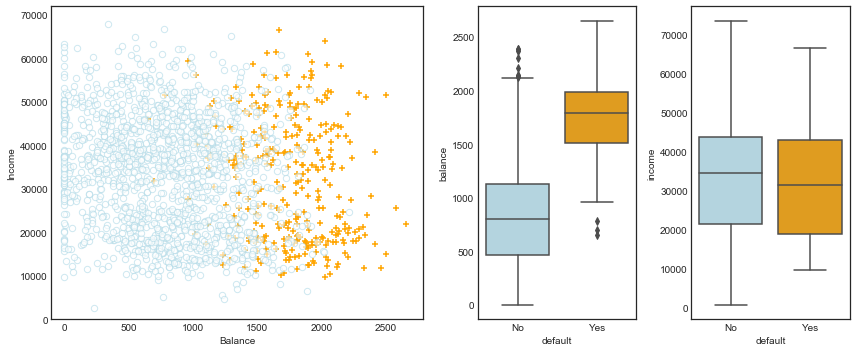

In [4]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

-----------------------------------------------
### 7.1 Logistic Regression

Recall our fit to the Titanic data from last week and the dilemma that some predictions and interpretations (such as the intercept) often led to survival probabilities outside the range $[0,1]$.

In [8]:
est = smf.ols('survived ~ age + C(pclass) + C(sex)', titanic).fit()
est.summary()#.tables[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     113.4
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           9.96e-75
Time:                        14:50:29   Log-Likelihood:                -328.84
No. Observations:                 714   AIC:                             667.7
Df Residuals:                     709   BIC:                             690.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1250      0.051     22.202      0.000       1.026       1.225
C(pclass)[T.2]    -0.2077      0.042     -4.983      0.000      -0.290      -0.126
C(pclass)[T.3]    -0.4066      0.038    -10.620      0.000      -0.482      -0.331
C(sex)[T.male]    -0.4795      0.031    -15.608      0.000      -0.540      -0.419
age               -0.0055      0.001     -5.039      0.000      -0.008      -0.003
==============================================================================
Omnibus:                       24.606   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.461
Skew:                           0.471   Prob(JB):                     1.80e-06
Kurtosis:                       3.046   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is not the only shortcoming of **linear** regression (LR) for binary outcomes! Other problems include heteroskedasticity and incorrect scaling of probabilities even inside the range $[0,1]$.

One solution is to transform the linear output of the (LR) to an S-shape via the **sigmoidal** function $s(z) = 1/(1+exp(-z))$, which is the strategy taken by **logistic regression** (example: Figure 4.2 from the ISLR book):

coefficients:  [[0.005]]
intercept : [-10.651]


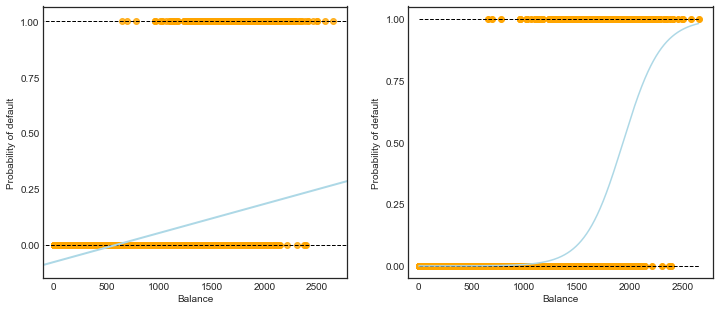

In [6]:
##first the sklearn module LogisticRegression
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
#compare to Table 4.1 which was obtained with R:
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

#optional fpr later blogs/publications:   
#fig.savefig('figures/Figure4.2.svg')

In [7]:
# now statsmodels:
#X_train = sm.add_constant(df.balance)
#est = smf.Logit(y.ravel(), X_train).fit()

est = smf.logit('default2 ~ balance', data=df)
est.fit().summary()

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

In [ ]:
#Mini Tasks: fit a logistic regression to the Titanic data
#Try to make sense of the coefficients!
est = smf.logit('survived ~ age + C(pclass) + C(sex)', data=titanic)
est.fit().summary()#.tables[1]

#### 7.1.1 Coefficients as Odds

For "normal regression" we know that the value of $\beta_j$ simply gives us $\Delta y$ if $x_j$ is increased by one unit.

In order to fully understand the exact meaning of the coefficients for a LR model we need to first warm up to the definition of a **link function** and the concept of **probability odds**.

Using linear regression as a starting point

$$
y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \ldots +\beta_k x_{k,i} + \epsilon_i
$$

we modify the right hand side such that (i) the model is still basically a linear combination of the $x_j$s but (ii) the output is -like a probability- bounded between 0 and 1. This is achieved by "wrapping" a sigmoid function $s(z) = 1/(1+exp(-z))$ around the weighted sum of the $x_j$s:

$$
y_i = s(\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \ldots +\beta_k x_{k,i} + \epsilon_i)
$$

The sigmoid function, depicted below to the left, transforms the real axis to the interval $(0;1)$ and can be interpreted as a probability.

![sigmoid](figures/Sigmoid.png)

The inverse of the sigmoid is the *logit* (depicted above to the right), which is defined as $log(p/(1-p))$. For the case where p is a probability we call the ratio $p/(1-p)$ the **probability odds**. Thus, the logit is the log of the odds and logistic regression models these *log-odds* as a linear combination of the values of x.

Finally, we can interpret the coefficients directly: the odds of a positive outcome are multiplied by a factor of $exp(\beta_j)$ for every unit change in $x_j$.
(In that light, logistic regression is reminiscient of linear regression with logarithmically transformed dependent variable which also leads to multiplicative rather than additive effects.)

Summary

$$
p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}}{1 + e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}}
$$
Odds 
$$
\frac{p(x)}{1-p(x)} = e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}
$$

This post has a more detailed view on the interpretations of the coefficients:

https://blog.hwr-berlin.de/codeandstats/interpretation-of-the-coefficients-in-logistic-regression/

#### Comments

1. When your data are **linearly separable** there is (ironically) a fitting problem ! See iris example below
2. *Logistic regression preserves the marginal probabilities.* 
The sum of the predicted probability scores for any subgroup of the training data (which includes all of it) will be equal to the number of positives.

3. *What is deviance ?*
Deviance (also referred to as *log loss*) is a measure of how well the model fits the data. It is 2 times the negative log likelihood of the dataset, given the model. 
$$
dev = - \sum_i{y_i \cdot \log p_i + (1-y_i) \cdot \log (1-p_i)}
$$
In Python, you can use the log_loss function from scikit-learn, with documentation found here:
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html 
If you think of deviance as analogous to variance, then the null deviance is similar to the variance of the data around the average rate of positive examples. The residual deviance is similar to the variance of the data around the model. As an exercise we will calculate the deviances in a homework.

In [ ]:
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  if true_label == 1:
    return -log(p)
  else:
    return -log(1 - p)

#### 7.1.2 Think Stats Data

do not run this cell, for completeness, I show how the joined dataframe was created:

    from __future__ import print_function, division
    import numpy as np
    import nsfg

    preg = pd.read_hdf('../data/pregNSFG.h5', 'df')
    #only look at live births
    live = preg[preg.outcome == 1]

    live = live[live.prglngth>30]
    resp = nsfg.ReadFemResp()
    resp.index = resp.caseid
    join = live.join(resp, on='caseid', rsuffix='_r')
    #save to native python format:
    #http://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.to_hdf.html
    join.to_hdf('JoinedpregNSFG.h5', key='df', format='table',complevel =9)

In [ ]:
live = pd.read_hdf('../data/JoinedpregNSFG.h5', 'df')

#define first babies
firsts = live[live.birthord == 1]
#and all others:
others = live[live.birthord != 1]


In [ ]:
# from this discussion, it seems that statsmodels still uses the defunct
# chisqprob, so we have to define it ourselves:
# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
stats.chisqprob(10,3)

The mother's age seems to have a small, non significant effect.

In [ ]:
live['boy'] = (live.babysex==1).astype(int)
SexvsAge = smf.logit('boy ~ agepreg', data=live)
results = SexvsAge.fit()
results.summary()

In [ ]:
# here's the best model that the author could find:
# (task: can we find out the meaning of the 2 new variables??)
formula='boy ~ agepreg + fmarout5==5 + infever==1'
model = smf.logit(formula, data=live)
results = model.fit()
results.summary()

### 7.1.3 Tasks

1. Use cross validation to estimate some accuracy measure of classification for the 
    * Titanic survival
    * sex prediction for the NSFG data
2. Translate the coefficient for Pclass 3 into both odds and probability of survival (compared to the reference level Pclass 1).
3. Compute the survival probability of the first passenger in the data set.

### 7.1.4 The Iris dataset

![iris](figures/irisDataCamp.png)


In [ ]:
from sklearn import datasets

plt.style.use('ggplot')
iris = datasets.load_iris()
print(iris.data.shape)

X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
#_ = pd.scatter_matrix(df, c = y, figsize = [8, 8],s=150, marker = 'D')

Looks like we could build a perfect classifier with just *petal width* ?

![iris2](figures/irisDataCampPairwise.png)


In [ ]:
iris.feature_names


In [ ]:
df["setosa"]= (y==0)
#I failed to rename, arrrg:
#df["petalwidth"] = df["petal width (cm)"]
#df["petallength"] = df["petal length (cm)"]
df.head()
df.columns

In [ ]:
X = iris["data"][:,3:]  # petal width

logit = sm.Logit((iris["target"]==0).astype(np.int), X)
logit.fit().params

In [ ]:
#model = smf.logit("setosa ~ petallength", data=df)
#results = model.fit()
#results.summary()

In [ ]:
#sklearn
from sklearn.linear_model import LogisticRegression

def LogReg(xCol=3, target=2,penalty="l2"):
    X = iris["data"][:,xCol:]  # petal width
    y = (iris["target"]==target).astype(np.int)

    log_reg = LogisticRegression(penalty=penalty)
    log_reg.fit(X,y)

    X_new = np.linspace(0,3,1000).reshape(-1,1)
    y_proba = log_reg.predict_proba(X_new)

    flowerType=["setosa", "versicolor", "virginica"]
 
    plt.plot(X,y,"b.")
    plt.plot(X_new,y_proba[:,1],"g-",label=flowerType[target])
    plt.plot(X_new,y_proba[:,0],"b--",label="not " + flowerType[target])
    plt.xlabel(iris.feature_names[xCol], fontsize=14)
    plt.ylabel("Probability", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.show()
    
    return log_reg

log_reg = LogReg()

log_reg.predict([[1.7],[1.5]])

In [ ]:
log_reg = LogReg(target=0)

----------------------------------------------------------
### 7.2 Other Classifiers

##### 7.2.1 K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(iris['data'], iris['target'])



Task: Split the iris data into training and test. Predict on test

In [ ]:
#prediction = knn.predict(X_test)
#print('Prediction {}’.format(prediction))

#### 7.2.2 Multinomial Logistic Regression

In [ ]:
import statsmodels.api as st
#different way of importing data
iris = st.datasets.get_rdataset('iris', 'datasets')
 
y = iris.data.Species
 
y.head(3)

x = iris.data.iloc[:, 0]
 
x = st.add_constant(x, prepend = False)
 
x.head()

In [ ]:
mdl = st.MNLogit(y, x)
 
mdl_fit = mdl.fit()

mdl_fit.summary()

In [ ]:
### marginal effects ###
 
mdl_margeff = mdl_fit.get_margeff()
 
mdl_margeff.summary()